In [11]:
from pathlib import Path
import getpass

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubStatistical,
    Geometry,
    parse_time,
)

In [12]:
# Commented out to avoid overwriting existing config
# Comment in to create new config:

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")
config = SHConfig("cdse")

In [13]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.NO2] 
}
"""

In [14]:
bbox_europe = BBox([-12.30, 34.59, 32.52, 63.15], crs=CRS.WGS84).transform(CRS(3857))
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2023-01-01", "2023-05-26"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(5500, 3500),
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

In [7]:
raw_data = request_raw.get_data(save_data=True)

For contextual mapping and spatial aggregation, this notebook uses publicly available administrative boundary shapefiles from the Natural Earth dataset (Admin 0 – Countries, 1:50m scale). These files contain the polygon geometries of countries and are used only for visualization and zonal statistics. They are not part of the Sentinel-5P satellite data.

[Download Link](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip)

In [9]:
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox_europe.min_x : bbox_europe.max_x, bbox_europe.min_y : bbox_europe.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

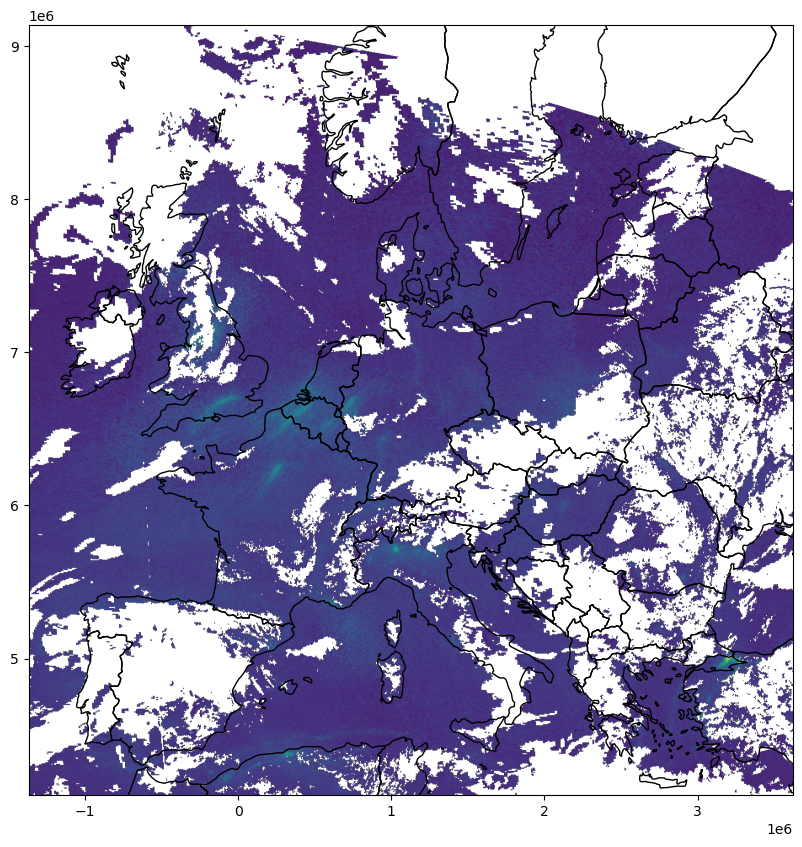

In [10]:
plot_request(request_raw, bbox_europe)